In [33]:
# %pip install numpy pandas pillow scikit-learn kagglehub matplotlib ipython
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !conda install -c conda-forge background-generator -y


In [ ]:
!pip install chromadb

In [ ]:
import chromadb
from chromadb.config import Settings
import json

In [34]:
import os
import pandas as pd
import numpy as np
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [35]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA version:", torch.version.cuda)
    print("Device name:", device)
else:
    device = torch.device("cpu")
    print("CUDA is not available")
    print("Device name:", device)


CUDA version: 12.4
Device name: cuda


In [36]:
class Display:
    @staticmethod
    def image_Display(image):
        if torch.is_tensor(image):
            image = image.detach().cpu().numpy()

        if image.ndim == 1:
            image = image.reshape(28,28)

        image = image.astype('uint8')  # ensure proper display format

        display(Image.fromarray(image, mode='L'))


In [37]:
# def convert_merged_csv_to_pt(train_csv_path, test_csv_path, pt_path):
#     dtype_map = {'label': 'int64'} | {str(i): 'uint8' for i in range(1, 785)}
#
#     df_train = pd.read_csv(train_csv_path, dtype=dtype_map, low_memory=False)
#     df_test = pd.read_csv(test_csv_path, dtype=dtype_map, low_memory=False)
#
#     df = pd.concat([df_train, df_test], ignore_index=True).sample(frac=1, random_state=42)
#
#     pixel_array = df.drop(columns='label').to_numpy(dtype='float32', copy=True)
#     label_array = df['label'].to_numpy(dtype='int64', copy=True)
#
#     pixels = torch.from_numpy(pixel_array)
#     labels = torch.from_numpy(label_array)
#
#     torch.save((pixels, labels), pt_path)
#     print(f"✅ Saved: {pt_path}")
#
# convert_merged_csv_to_pt("Dataset/mnist_train.csv", "Dataset/mnist_test.csv", "Dataset/mnist.pt")

In [38]:
class Dataset(Dataset):
    def __init__(self, pt_path):
        self.pixels, self.labels = torch.load(pt_path, weights_only=True)

    def __getitem__(self, index):
        return self.pixels[index], self.labels[index]

    def __len__(self):
        return self.labels.size(0)

In [39]:
# def benchmark_workers(pt_path="Dataset/mnist.pt", max_workers=12, batch_size=512):
#     dataset = Dataset(pt_path)
#     indices = np.arange(len(dataset))
#     train_idx, _ = train_test_split(indices, test_size=0.2, shuffle=True)
#     train_set = Subset(dataset, train_idx)
#
#
#     for nw in range(max_workers + 1):
#         loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
#                                              num_workers=nw, pin_memory=True,
#                                              persistent_workers=(nw > 0))
#         torch.cuda.synchronize() if torch.cuda.is_available() else None
#         t0 = time.perf_counter()
#
#         for x, y in loader:
#             pass  # simulate one epoch
#
#         torch.cuda.synchronize() if torch.cuda.is_available() else None
#         t1 = time.perf_counter()
#         print(f"num_workers={nw:<2} | time: {t1 - t0:.3f} sec")
#
# benchmark_workers()

In [40]:
class Dataloaders:
    def __init__(self, dataset_cls):
        self.dataset_cls = dataset_cls

    def get(self, pt_path, batch_size=5, test_size=0.1, num_workers=0):
        dataset = self.dataset_cls(pt_path)

        indices = np.arange(len(dataset))
        train_idx, test_idx = train_test_split(indices, test_size=test_size, shuffle=True)

        train_set = Subset(dataset, train_idx)
        test_set = Subset(dataset, test_idx)

        effective_batch_size = len(train_set) if batch_size is None else batch_size

        train_loader = DataLoader(train_set, batch_size=effective_batch_size, shuffle=True,
                                  num_workers=num_workers, pin_memory=True,
                                  persistent_workers=(num_workers > 0))

        test_loader = DataLoader(test_set, batch_size=len(test_set) if batch_size is None else batch_size,
                                 shuffle=False, num_workers=num_workers, pin_memory=True,
                                 persistent_workers=(num_workers > 0))

        return train_loader, test_loader


In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
loaders = Dataloaders(Dataset)

train_loader, test_loader = loaders.get("/content/drive/MyDrive/Dataset/mnist.pt", batch_size=10)

for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)


    print(x.shape, y.shape)
    break


torch.Size([10, 784]) torch.Size([10])


In [43]:
class Scaling(nn.Module):
    def __init__(self, input_tensor: torch.Tensor, bounds=(0.0, 255.0)):
        super().__init__()

        self.device = input_tensor.device
        self.input_dtype = input_tensor.dtype

        min_val = input_tensor.min()
        max_val = input_tensor.max()

        lower, upper = map(float, bounds)
        delta_mm = max_val - min_val
        delta_ul = upper - lower

        a = delta_mm + delta_ul
        b = lower * delta_mm + min_val * delta_ul
        c = 2 * delta_mm * delta_ul

        self.register_buffer("a", a)
        self.register_buffer("b", b)
        self.register_buffer("c", c)

    def forward(self, input_tensor: torch.Tensor):
        if self.c == 0: return input_tensor
        return (self.a * input_tensor - self.b) / self.c

    @torch.no_grad()
    def inverse(self, scaled_tensor: torch.Tensor):
        if self.c == 0: return scaled_tensor
        return (self.c * scaled_tensor + self.b) / self.a


In [44]:
class Classifier(nn.Module):
    def __init__(self, categories: int):
        super().__init__()
        self.categories = categories

    def forward(self, labels: torch.Tensor) -> torch.Tensor:
        return F.one_hot(labels.view(-1), num_classes=self.categories).float()

    @torch.no_grad()
    def inverse(self, one_hot_tensor: torch.Tensor) -> torch.Tensor:
        return one_hot_tensor.argmax(dim=1, keepdim=True)


In [45]:
for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)


    bounds = (0.0, 255.0)
    Scaling1 = Scaling(x, bounds)
    Classifier1 = Classifier(10).to(device, non_blocking=True)


    print(x.shape, y.shape)
    break

torch.Size([10, 784]) torch.Size([10])


In [46]:
#----
#Global dictionary to hold activations for current epoch
current_epoch_activations = {}

# Per-epoch neuron value store
all_epoch_activations = []  # List of dicts

# Hook function
def get_activation(name):
    def hook(model, input, output):
        if name not in current_epoch_activations:
            current_epoch_activations[name] = []
        current_epoch_activations[name].append(output.detach().cpu())  # Collect batch output
    return hook

#----

In [47]:
current_epoch_activations

{}

In [48]:
for layer_name, batch_outputs in current_epoch_activations.items():
    print(f"Layer: {layer_name}")
    for i, tensor in enumerate(batch_outputs):
        print(f"  Batch {i}: shape = {tensor.shape}")


In [49]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_sizes = [784, 121, 25, 10]
        self.net = nn.Sequential(
            nn.Linear(self.layer_sizes[0], self.layer_sizes[1], bias=True),
            nn.Sigmoid(),                       # fused activation
            nn.Linear(self.layer_sizes[1], self.layer_sizes[2], bias=True),
            nn.ReLU(inplace=True),              # in‑place
            nn.Linear(self.layer_sizes[2], self.layer_sizes[3], bias=True),
            nn.Softmax(dim=1)
        )

        nn.init.xavier_uniform_(self.net[0].weight)
        nn.init.uniform_(self.net[0].bias, -1.0/math.sqrt(self.layer_sizes[0]), 1.0/math.sqrt(self.layer_sizes[0]))
        nn.init.kaiming_normal_(self.net[2].weight, nonlinearity='relu')
        nn.init.uniform_(self.net[2].bias, -1.0/math.sqrt(self.layer_sizes[1]), 1.0/math.sqrt(self.layer_sizes[1]))
        nn.init.xavier_normal_(self.net[4].weight)
        nn.init.uniform_(self.net[4].bias, -1.0/math.sqrt(self.layer_sizes[2]), 1.0/math.sqrt(self.layer_sizes[2]))

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = x.contiguous()
        return self.net(x)

In [50]:
for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    bounds = (0.0, 255.0)
    Scaling1 = Scaling(x, bounds)
    Classifier1 = Classifier(10).to(device, non_blocking=True)
    net = NN().to(device, non_blocking=True)

    x_scaled = Scaling1(x)
    y_encoded = Classifier1(y)

    yHAT = net(x_scaled)
    loss = net.loss_fn(yHAT, y)
    print("CrossEntropy Loss:", loss.item())


    print(x_scaled.shape, y_encoded.shape, yHAT.shape)
    break


CrossEntropy Loss: 2.288728713989258
torch.Size([10, 784]) torch.Size([10, 10]) torch.Size([10, 10])


In [51]:
class UltraFastTrainer:
    def __init__(
        self,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer_cls=torch.optim.Adam,
        lr=1e-3,
        max_epochs=50,
        clip_grad_norm=1.0,
        use_amp=True,
        use_tqdm=False,
        save_path=None
    ):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer_cls(model.parameters(), lr=lr)
        self.max_epochs = max_epochs
        self.clip_grad_norm = clip_grad_norm
        self.use_amp = use_amp
        self.save_path = save_path
        self.use_tqdm = use_tqdm

        self.scaler_amp = GradScaler(enabled=use_amp)
        self.loss_history = []

    def _prefetch_loader(self, loader):
        for x, y in loader:
            yield x.to(device, non_blocking=True), y.to(device, non_blocking=True)

    def train(self, train_loader):
        self.model.train()

        x_sample, _ = next(iter(train_loader))
        scaler = Scaling(x_sample.to(device))

        for epoch in range(1, self.max_epochs + 1):
            start = time.perf_counter()
            total_loss = 0.0
            #-----
            global current_epoch_activations
            current_epoch_activations = {}  # Reset here
            #-----
            iterable = self._prefetch_loader(train_loader)
            if self.use_tqdm:
                iterable = tqdm(iterable, desc=f"Epoch {epoch}", leave=False)
            i = 1
            for x, y in iterable:
                x = scaler(x)
                print(f"x shape:{i}-{x.size()}")
                #----
                if 'input' not in current_epoch_activations:
                  current_epoch_activations['input'] = []
                current_epoch_activations['input'].append(x.detach().cpu())
                #----
                self.optimizer.zero_grad(set_to_none=True)

                with autocast(device_type=device.type, enabled=self.use_amp):
                    y_pred = self.model(x)
                    loss = self.loss_fn(y_pred, y)

                self.scaler_amp.scale(loss).backward()

                if self.clip_grad_norm:
                    self.scaler_amp.unscale_(self.optimizer)
                    nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)

                self.scaler_amp.step(self.optimizer)
                self.scaler_amp.update()
                i +=1

                total_loss += loss.item()
                break
            #------
            # ✅ Moved here: after the whole epoch
            epoch_result = {
                layer_name: torch.cat(outputs, dim=0)
                for layer_name, outputs in current_epoch_activations.items()
            }

            all_epoch_activations.append(epoch_result)

            print(f"\n[Epoch {epoch}] Activation shapes:")
            for name, val in epoch_result.items():
                print(f"  {name}: {val.shape}")
            #------
            avg_loss = total_loss / len(train_loader)
            self.loss_history.append(avg_loss)

            elapsed = time.perf_counter() - start
            print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Time: {elapsed:.2f}s")

        if self.save_path:
            torch.save(self.model.state_dict(), self.save_path)


    def evaluate(self, test_loader):
        self.model.eval()
        correct, total = 0, 0

        scaler = Scaling(next(iter(test_loader))[0].to(device))

        with torch.no_grad():
            for x, y in self._prefetch_loader(test_loader):
                x = scaler(x)
                pred = self.model(x).argmax(dim=1)
                correct += (pred == y.view(-1)).sum().item()
                total += y.size(0)

        acc = correct / total
        print(f"Test Accuracy: {acc*100:.2f}%")
        return acc

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


x shape:1-torch.Size([10, 784])

[Epoch 1] Activation shapes:
  input: torch.Size([10, 784])
  layer_0: torch.Size([10, 121])
  layer_2: torch.Size([10, 25])
  layer_4: torch.Size([10, 10])
Epoch 001 | Loss: 0.0004 | Time: 0.01s
x shape:1-torch.Size([10, 784])

[Epoch 2] Activation shapes:
  input: torch.Size([10, 784])
  layer_0: torch.Size([10, 121])
  layer_2: torch.Size([10, 25])
  layer_4: torch.Size([10, 10])
Epoch 002 | Loss: 0.0004 | Time: 0.01s
x shape:1-torch.Size([10, 784])

[Epoch 3] Activation shapes:
  input: torch.Size([10, 784])
  layer_0: torch.Size([10, 121])
  layer_2: torch.Size([10, 25])
  layer_4: torch.Size([10, 10])
Epoch 003 | Loss: 0.0004 | Time: 0.01s
x shape:1-torch.Size([10, 784])

[Epoch 4] Activation shapes:
  input: torch.Size([10, 784])
  layer_0: torch.Size([10, 121])
  layer_2: torch.Size([10, 25])
  layer_4: torch.Size([10, 10])
Epoch 004 | Loss: 0.0004 | Time: 0.01s
x shape:1-torch.Size([10, 784])

[Epoch 5] Activation shapes:
  input: torch.Size([1

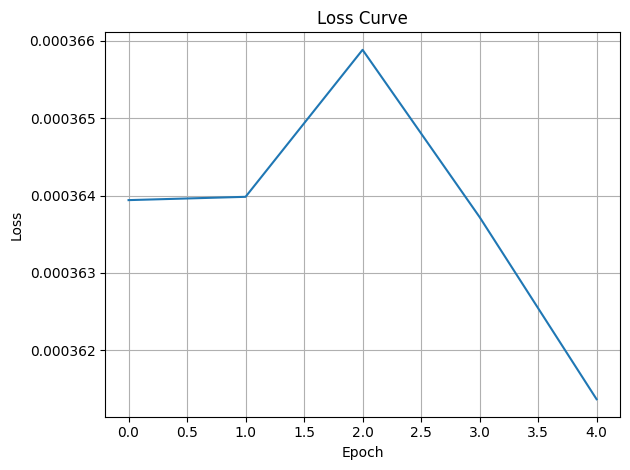

In [52]:
model = NN()
#----
for idx, layer in enumerate(model.net):
    if isinstance(layer, nn.Linear):
        layer.register_forward_hook(get_activation(f"layer_{idx}"))

#----

trainer = UltraFastTrainer(model, nn.CrossEntropyLoss(), max_epochs=5, use_amp=True)

trainer.train(train_loader)
trainer.evaluate(test_loader)
trainer.plot_loss()


In [53]:
(all_epoch_activations)[0]['layer_0']

tensor([[-8.7988e-01,  4.5850e-01,  2.6535e-02,  ...,  1.2988e+00,
          1.0712e-01,  4.9219e-01],
        [-2.4536e-01,  9.7290e-02,  1.0791e-01,  ...,  4.5093e-01,
         -1.2061e-01,  2.5708e-01],
        [-4.8645e-02, -7.4707e-01,  1.9714e-01,  ...,  3.8965e-01,
          2.9272e-01, -2.4573e-01],
        ...,
        [-1.1212e-01,  3.5303e-01, -1.8384e-01,  ...,  2.6099e-01,
         -1.4954e-01, -1.7175e-01],
        [-4.7412e-01,  6.4331e-02,  8.7012e-01,  ...,  4.2139e-01,
          2.8839e-02, -8.4106e-02],
        [-4.3530e-01, -1.0735e-02, -7.9639e-01,  ...,  1.2817e-01,
          4.3726e-04,  1.6449e-02]], dtype=torch.float16)

In [54]:
print(f"\nTotal epochs stored: {len(all_epoch_activations)}")
for epoch_idx, data in enumerate(all_epoch_activations):
    print(f"Epoch {epoch_idx + 1}")
    for layer_name, tensor in data.items():
        print(f"  {layer_name}: {tensor.shape}")



Total epochs stored: 5
Epoch 1
  input: torch.Size([10, 784])
  layer_0: torch.Size([10, 121])
  layer_2: torch.Size([10, 25])
  layer_4: torch.Size([10, 10])
Epoch 2
  input: torch.Size([10, 784])
  layer_0: torch.Size([10, 121])
  layer_2: torch.Size([10, 25])
  layer_4: torch.Size([10, 10])
Epoch 3
  input: torch.Size([10, 784])
  layer_0: torch.Size([10, 121])
  layer_2: torch.Size([10, 25])
  layer_4: torch.Size([10, 10])
Epoch 4
  input: torch.Size([10, 784])
  layer_0: torch.Size([10, 121])
  layer_2: torch.Size([10, 25])
  layer_4: torch.Size([10, 10])
Epoch 5
  input: torch.Size([10, 784])
  layer_0: torch.Size([10, 121])
  layer_2: torch.Size([10, 25])
  layer_4: torch.Size([10, 10])


In [55]:
'input' in all_epoch_activations[0]

True

Visualisation of the stored data

In [56]:
import matplotlib.pyplot as plt

def show_activation_grid(activation_dict, sample_idx):
    layer_shapes = {
        'input': (28, 28),
        'layer_0': (11, 11),
        'layer_2': (5, 5),
        'layer_4': (1, 10)
    }

    num_layers = len(layer_shapes)
    plt.figure(figsize=(10, 2.5))

    for i, (layer_name, shape) in enumerate(layer_shapes.items()):
        activation = activation_dict[layer_name][sample_idx]

        # ✅ Convert to float32 before reshaping and plotting
        activation = activation.to(torch.float32).numpy().reshape(shape)
        plt.suptitle(f"Epoch Index = {epoch_idx}, Sample Index = {sample_idx}")
        plt.subplot(1, num_layers, i + 1)
        plt.imshow(activation, cmap='gray')
        plt.title(layer_name)

        plt.axis('off')


    plt.tight_layout()
    plt.show()

In [57]:

epoch_idx = 4    # Which epoch to visualize
sample_idx = 5     # Which sample (out of 63700) to visualize


In [58]:
# show_activation_grid(all_epoch_activations[epoch_idx], sample_idx)


In [59]:
# for epoch_idx in range(5):
#   for num in range(11):
#     show_activation_grid(all_epoch_activations[epoch_idx], num)

Storing in Vector Database (Chroma):

In [85]:
epoch1 = all_epoch_activations[0]
epoch2 = all_epoch_activations[1]
epoch3 = all_epoch_activations[2]
epoch4 = all_epoch_activations[3]
epoch5 = all_epoch_activations[4]



In [86]:
epoch{i} has values of 4 layers for all i = 1,2,3,4,5

Following data is in form of tensors (which is incompatible with json.) Will change to list.

epoch{0}['input'] has shape [10,784]. It has values of 10 images in form of 784 pixels.

epoch{0}['layer_0'] has shape [10,121]. It has values of 121 neurons for all 10 input Images.

epoch{0}['layer_2'] has shape [10,25]. It has values of 25 neurons for all 10 input Images.

epoch{0}['layer_4'] has shape [10,10]. It has values of 10 neurons for all 10 input Images.




epoch{1}['input'] has shape [10,784]. It has values of 10 images in form of 784 pixels.

epoch{1}['layer_0'] has shape [10,121]. It has values of 121 neurons for all 10 input Images.

epoch{1}['layer_2'] has shape [10,25]. It has values of 25 neurons for all 10 input Images.

epoch{1}['layer_4'] has shape [10,10]. It has values of 10 neurons for all 10 input Images.




epoch{2}['input'] has shape [10,784]. It has values of 10 images in form of 784 pixels.

epoch{2}['layer_0'] has shape [10,121]. It has values of 121 neurons for all 10 input Images.

epoch{2}['layer_2'] has shape [10,25]. It has values of 25 neurons for all 10 input Images.

epoch{2}['layer_4'] has shape [10,10]. It has values of 10 neurons for all 10 input Images.




epoch{3}['input'] has shape [10,784]. It has values of 10 images in form of 784 pixels.

epoch{3}['layer_0'] has shape [10,121]. It has values of 121 neurons for all 10 input Images.

epoch{3}['layer_2'] has shape [10,25]. It has values of 25 neurons for all 10 input Images.

epoch{3}['layer_4'] has shape [10,10]. It has values of 10 neurons for all 10 input Images.



epoch{4}['input'] has shape [10,784]. It has values of 10 images in form of 784 pixels.

epoch{4}['layer_0'] has shape [10,121]. It has values of 121 neurons for all 10 input Images.

epoch{4}['layer_2'] has shape [10,25]. It has values of 25 neurons for all 10 input Images.

epoch{4}['layer_4'] has shape [10,10]. It has values of 10 neurons for all 10 input Images.

4

In [94]:
epoch1['layer_0'].shape

torch.Size([10, 121])

In [103]:
# json_ready_dict = {}
# json_ready_dict.update({'input': [1,2,3]})

# json_ready_dict["layer__22"] = [1,2,3,4,5]
json_ready_dict

{}

'layer_4'

In [124]:
for layers in ["input", 'layer_0', 'layer_2', 'layer_4']:
  print(len(all_epoch_activations[0][layers][9]))

784
121
25
10


In [130]:
for i in range(10):
  for j in range (trainer.max_epochs):
    print(f"Epoch{j+1} Sample{i}")
    # print(all_epoch_activations[i]['input'])
    for layers in ['input', 'layer_0', 'layer_2', 'layer_4']:
      print(len(all_epoch_activations[j][layers][i]))


    all_epoch_activations[epoch_number][layer_name][anySpecificSample(optional)]

Epoch1 Sample0
784
121
25
10
Epoch2 Sample0
784
121
25
10
Epoch3 Sample0
784
121
25
10
Epoch4 Sample0
784
121
25
10
Epoch5 Sample0
784
121
25
10
Epoch1 Sample1
784
121
25
10
Epoch2 Sample1
784
121
25
10
Epoch3 Sample1
784
121
25
10
Epoch4 Sample1
784
121
25
10
Epoch5 Sample1
784
121
25
10
Epoch1 Sample2
784
121
25
10
Epoch2 Sample2
784
121
25
10
Epoch3 Sample2
784
121
25
10
Epoch4 Sample2
784
121
25
10
Epoch5 Sample2
784
121
25
10
Epoch1 Sample3
784
121
25
10
Epoch2 Sample3
784
121
25
10
Epoch3 Sample3
784
121
25
10
Epoch4 Sample3
784
121
25
10
Epoch5 Sample3
784
121
25
10
Epoch1 Sample4
784
121
25
10
Epoch2 Sample4
784
121
25
10
Epoch3 Sample4
784
121
25
10
Epoch4 Sample4
784
121
25
10
Epoch5 Sample4
784
121
25
10
Epoch1 Sample5
784
121
25
10
Epoch2 Sample5
784
121
25
10
Epoch3 Sample5
784
121
25
10
Epoch4 Sample5
784
121
25
10
Epoch5 Sample5
784
121
25
10
Epoch1 Sample6
784
121
25
10
Epoch2 Sample6
784
121
25
10
Epoch3 Sample6
784
121
25
10
Epoch4 Sample6
784
121
25
10
Epoch5 Sample6

In [144]:
tens_to_list = []
for i in range(10):
  for j in range (trainer.max_epochs):
    # print(f"Epoch{j} Sample{i}")
    # print(all_epoch_activations[i]['input'])
    for layers in ['input', 'layer_0', 'layer_2', 'layer_4']:
      tens_to_list += (all_epoch_activations[j][layers][i]).tolist()




In [148]:
len(tens_to_list)

47000

In [156]:
nested = {}

In [161]:
model.net

Sequential(
  (0): Linear(in_features=784, out_features=121, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=121, out_features=25, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=25, out_features=10, bias=True)
  (5): Softmax(dim=1)
)

In [159]:
nested = {
    'e0' : { 'l0' : (all_epoch_activations[0]['input']).tolist(), 'l1': (all_epoch_activations[0]['layer_0']).tolist()}
}


In [162]:
# Required variables
numberofepoch = 5
layers = ['input', 'layer_0', 'layer_2', 'layer_4']

In [208]:
nested = {}
for i in range(numberofepoch):
  nested[f'e{i}'] = {
    'l0': all_epoch_activations[i]['input'].tolist(),
    'l1': all_epoch_activations[i]['layer_0'].tolist(),
    'l2': all_epoch_activations[i]['layer_2'].tolist(),
    'l3': all_epoch_activations[i]['layer_4'].tolist()
}


In [210]:
len(nested['e4']['l3'])

10

In [211]:
json.dumps(nested)

'{"e0": {"l0": [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2823529541492462, 1.0, 1.0, 1.0, 1.0, 0.5686274766921997, 0.3019607961177826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411926865578, 0.16862745583057404, 0.8823529481887817, 0.9921568632125854, 0.9921568632125854, 0.9529411792755127, 0.9607843160629272, 0.9921568632125854, 0.552941203

In [ ]:
"""
Points to remember:
 metadata value to be a str, int, float, bool, or None, got {1, 5, 6} which is a set in add.
"""

In [ ]:
'''
Working plan =
1. Create chromadb
'''